In [1]:
"""
Created on Sun Mar 19 2023

@author: Rabah MOULAI
"""

import glob #files manipulation and dealing with directories      
import zipfile
import os 

import cv2 #reading and resizing 

import matplotlib.pyplot as plt # for visualizations
import matplotlib.image as mpimg
import seaborn as sns 

import numpy as np # for manipulating data
from collections import Counter
import pandas as pd
import random
import scipy

import tensorflow as tf  #For Creating an architecutre , training, evaluating and predicting 
from keras.models import Sequential
from keras.layers import Dense , Conv2D, Dropout , Activation , Flatten , Conv2D, MaxPooling2D,RandomFlip,RandomRotation, RandomZoom,Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,RocCurveDisplay,auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path


#1.Load Data

In [2]:
#HYPERPARAMETERS
image_size = 124  # resize inputs to this size
image_size_max = 3000 # if height or width  of inputs > image_max_size; it's an outlier; we will remove from Dataset

epochs = 25
batch_size = 32
print(os.getcwd())
path_Train_set = "Main\dataset\train" # path to train set 
path_Test_set = "Main\dataset\test"# path to test set

c:\Users\Utilisateur\Desktop\Trimble-Bilberry_AI_Engineer_technical_exercise\main


##1.1 Load_data

In [3]:
def Preprocessing(X, Y, Image_size, Image_Max_size) :

  
  """
      this function preprocesses the data set 

      it removes the images considered as outliers that exceed a certain height or width;
      it resize the images to a given size 
      it normalizes the dataset by dividing by 255  to convert the pixels in range [0,255] to range [0,1]

      Args:
          X (np.array) : the set of image features
          Y(np.array)  : the set of image label
          Image_size (int)   : the size at which we should resize the images 
          Image_Max_size (int) : the maximum size for which the image is not considered as an outlier  

      Returns:
          X_PreProcessing (np.array): the set of images features after having carried out the various pre-processing 
          Y_PreProcessing (np.array) : the set of images label after removing or not the outliers 

  """


  X_PreProcessing = []
  Y_PreProcessing = []
  cp=0
  for i in range (len(Y)) :
    #removing outiers 

    if X[i].shape[0] <= Image_Max_size or X[i].shape[1] <= Image_Max_size :
      #resize image to (image_size,image_size)

      X_PreProcessing.append(cv2.resize(X[i],(Image_size,Image_size)))
      Y_PreProcessing.append(Y[i])

  X_PreProcessing = np.array(X_PreProcessing).reshape(-1,Image_size,Image_size,3)
  Y_PreProcessing = np.array(Y_PreProcessing)

  #normalizing
  X_PreProcessing = X_PreProcessing * 1./255

  return X_PreProcessing, Y_PreProcessing



def DataAugmentation(X,Y) :

  """
     address class imbalance by oversampling the minority class also known as “class augmentation,” which involves adjusting 
     the number of samples in the minority class to improve the balance of the dataset.
     we will add new examples to the minority class by applying a small rotation of 20 degrees on the already existing examples, 
     until we reach the same number of examples as the majority class 

    Args:
        X (np.array) : the set of image features
        Y(np.array)  : the set of image label  

    Returns:
        X_PreProcessing (np.array) :  the set of images features after having carried out the DataAugmentation
        Y_PreProcessing (np.array) :  the newset of images label with label of the augmented images 
  """

  unique, counts             =   np.unique(Y, return_counts=True)
  Dict_Class_nb_imag         =   dict(zip(unique, counts)) # Dictionary with key : class value : number of images
  Number_img_majority_class  =   max(Dict_Class_nb_imag.values())# number of images for of the majority class 
  cp = 0
  

  #Data augmentation for class minority  by applying a rotation of 20 degrees
  for key,value in Dict_Class_nb_imag.items() : 
    for i in range(len(Y)) :
      
      if Y[i] == key and cp < (Number_img_majority_class - Dict_Class_nb_imag[key]) :

          cp += 1
          New_Xi  = np.expand_dims(scipy.ndimage.rotate(X[i],reshape=False,angle=20,mode='nearest'), axis = 0)
          X = np.concatenate((X,New_Xi),axis=0)
          Y = np.append(Y,Y[i])

    cp = 0

    return X, Y

Load images and set label for each image according to it's class: {
0 : Field ;
1 : Road } 

In [4]:

Categories = ['fields','roads']  # Our categories
X_shape_data, Y_shape_data = [],[] 
X,Y = [],[]
for category in Categories :
  path = os.path.join(os.getcwd(),path_Train_set,category) #Read images from fields and roads folder
  class_num = Categories.index(category)

  for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img))
      im_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
      
      X.append(im_rgb)    
      Y.append(class_num) #assign each image its own label 

      X_shape_data.append(im_rgb.shape[0])
      Y_shape_data.append(im_rgb.shape[1])




FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'c:\\Users\\Utilisateur\\Desktop\\Trimble-Bilberry_AI_Engineer_technical_exercise\\main\\Main\\dataset\train\\fields'

## 1.1 Explore and get insights from Data

* First think to do is to plot resolution of images, because if certain class images are of very high or low resolution: that Could makes the model biased


* Then check if the dataset is Balanced or no.



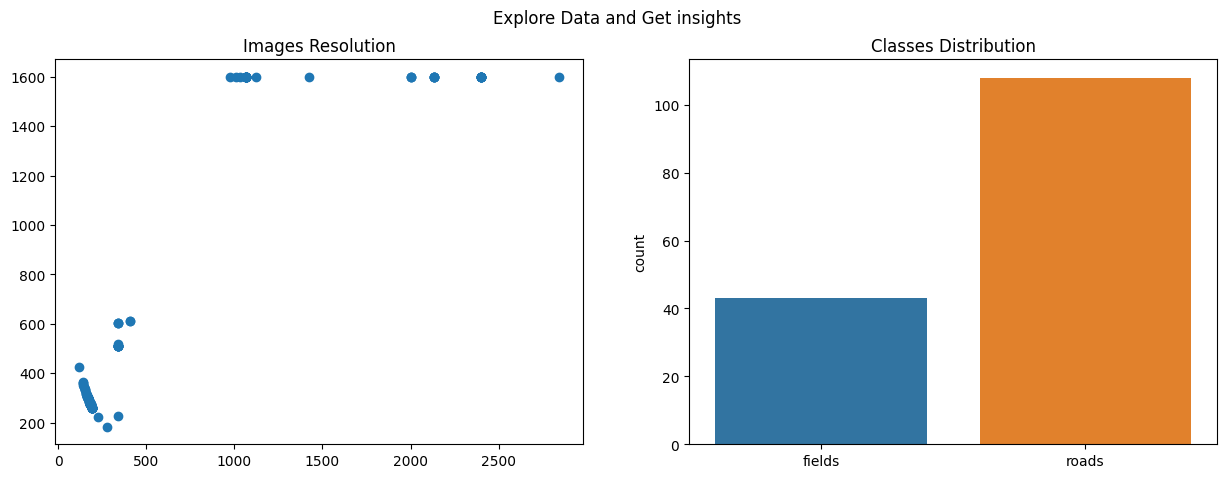

In [ ]:
figure, axes = plt.subplots(1, 2, sharex=False, figsize=(15,5))
figure.suptitle('Explore Data and Get insights')
axes[0].set_title('Images Resolution')
axes[1].set_title('Classes Distribution')


Y_label= ['fields'   if i == 0   else  "roads" for i in Y]

axes[0].scatter(X_shape_data,Y_shape_data)
sns.countplot(ax=axes[1],x = Y_label)
plt.savefig("Distribution.png")
plt.show()

From this two plots we can see that the dataset is unbalanced and we can clearly see that images are clustered around either size 550.

I decide to not remove the images with very resolution to ensure that the model will generalize further i will resize the images to ( 124  x 124  ) to keep up the compute limitaions.

i will balance the dataset manually with class augmentation (Oversampling the minority class)

1.2 Pre_Processing Data

As the test set is provided without labels, I chose to divide the training set into a test set to evaluate the model and a sub set for training and validation.
(80%training 20%test)

Note that the 10 images provided with the test set will be used as inferences for the prediction 

In [ ]:
#Preproce and augmente Data set
X_PreProcessing, Y_PreProcessing = Preprocessing(X, Y, image_size ,image_size_max) 
X_PreProcessing, Y_PreProcessing = DataAugmentation(X_PreProcessing, Y_PreProcessing)

#shuffling the Dataset 
Training_data = list(zip(X_PreProcessing, Y_PreProcessing))
random.shuffle(Training_data)
X_PreProcessing, Y_PreProcessing = zip(*Training_data)
X_PreProcessing, Y_PreProcessing = np.array(X_PreProcessing), np.array(Y_PreProcessing)

#split data 
X_train_PreProcessing, X_test_PreProcessing, Y_train_PreProcessing, Y_test_PreProcessing = train_test_split(X_PreProcessing, Y_PreProcessing, 
    test_size=0.20, random_state= 8) 
X_train_PreProcessing, X_val_PreProcessing, Y_train_PreProcessing, Y_val_PreProcessing = train_test_split(X_train_PreProcessing, Y_train_PreProcessing, 
    test_size=0.20, random_state= 8) 


In [ ]:
print(X_train_PreProcessing.shape)
print(X_val_PreProcessing.shape)
print(X_test_PreProcessing.shape)

(124, 124, 124, 3)
(31, 124, 124, 3)
(39, 124, 124, 3)






#Training model

Even after balancing our data set, the data set remains very small 

To improve this I will use ImageDataGenerator from tf.keras to augment the images with different augmentation techniques like  rotation, small Zoom and 
a horizontal flip. 

Other transformations were considered, such as rotations, vertical flipping, and applying a grayscale filter. These were not chosen, however, as they produce changes to the images that compromise their defining features. I also chose not to apply grayscale filtering, because the color gives important clues to the classification (e.g. fields are likely to have more green, roads likely to have more gray).

However, the main benefit of using the Keras ImageDataGenerator class is that it is designed to provide real-time data augmentation. Meaning it is generating augmented images on the fly while the model is still in the training stage. 

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    zoom_range = 0.1
    )

model Architecture inspired by  AlexNet architecture

In [ ]:
model = Sequential()

model.add(Conv2D(6,(5,5),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(6,(3,3),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(12,(3,3),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))



In [ ]:
model.compile(loss="binary_crossentropy",optimizer = "adam", metrics=["accuracy"])
history = model.fit(datagen.flow(X_train_PreProcessing, Y_train_PreProcessing, batch_size=batch_size),
         validation_data=(X_val_PreProcessing,Y_val_PreProcessing),
         steps_per_epoch=X_train_PreProcessing.shape[0] / batch_size, epochs=epochs)


Epoch 1/25
3/3 [==============================] - 5s 513ms/step - loss: 0.6829 - accuracy: 0.5726 - val_loss: 0.6593 - val_accuracy: 0.7097
Epoch 2/25
3/3 [==============================] - 1s 278ms/step - loss: 0.6721 - accuracy: 0.5565 - val_loss: 0.6170 - val_accuracy: 0.8065
Epoch 3/25
3/3 [==============================] - 1s 265ms/step - loss: 0.6558 - accuracy: 0.6290 - val_loss: 0.5024 - val_accuracy: 0.9032
Epoch 4/25
3/3 [==============================] - 1s 263ms/step - loss: 0.5920 - accuracy: 0.7258 - val_loss: 0.4949 - val_accuracy: 0.8710
Epoch 5/25
3/3 [==============================] - 1s 324ms/step - loss: 0.5509 - accuracy: 0.7500 - val_loss: 0.3678 - val_accuracy: 0.9355
Epoch 6/25
3/3 [==============================] - 2s 343ms/step - loss: 0.4829 - accuracy: 0.7984 - val_loss: 0.4035 - val_accuracy: 0.8065
Epoch 7/25
3/3 [==============================] - 1s 308ms/step - loss: 0.4631 - accuracy: 0.8065 - val_loss: 0.2802 - val_accuracy: 0.9032
Epoch 8/25
3/3 [====

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 6)     456       
                                                                 
 activation (Activation)     (None, None, None, 6)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 6)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 6)     330       
                                                                 
 activation_1 (Activation)   (None, None, None, 6)     0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 6)    0         
 2D)                                                    

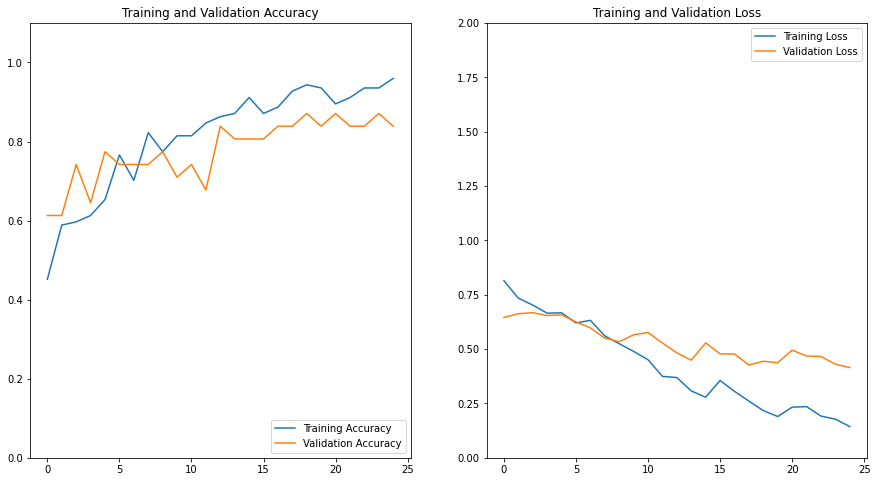

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylim(0,1.1)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylim(0,2)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Test and Evaluate Model


we evaluate our model with the test set but since it is a binary classifier we will not only evaluate the accuracy but also the ROC curve and the confusion matrix 

1.1 Accuracy 

In [ ]:
test_loss, test_acc = model.evaluate(X_test_PreProcessing,  Y_test_PreProcessing, verbose=2)

print('\nTest accuracy:', test_acc)

2/2 - 0s - loss: 0.2686 - accuracy: 0.8462 - 208ms/epoch - 104ms/step

Test accuracy: 0.8461538553237915


1.2 ROC curve

In [ ]:

y_pred= model.predict(X_test_PreProcessing).ravel()
fpr, tpr, thresholds= roc_curve(Y_test_PreProcessing, y_pred)

2/2 [==============================] - 0s 48ms/step


<Figure size 1080x504 with 0 Axes>

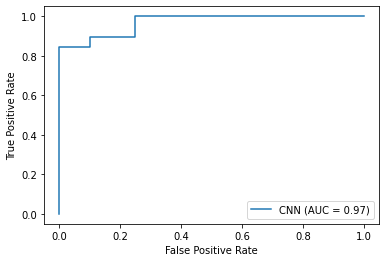

In [ ]:
plt.figure(figsize=(15,7))
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='CNN')
display.plot()
plt.show()

1.3 Confusion Matrix

In [ ]:
y_pred = np.round(y_pred)



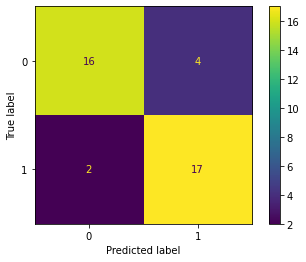

In [ ]:
cm = confusion_matrix(Y_test_PreProcessing,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Prédiction with inferencecs

1/1 [==============================] - 0s 35ms/step


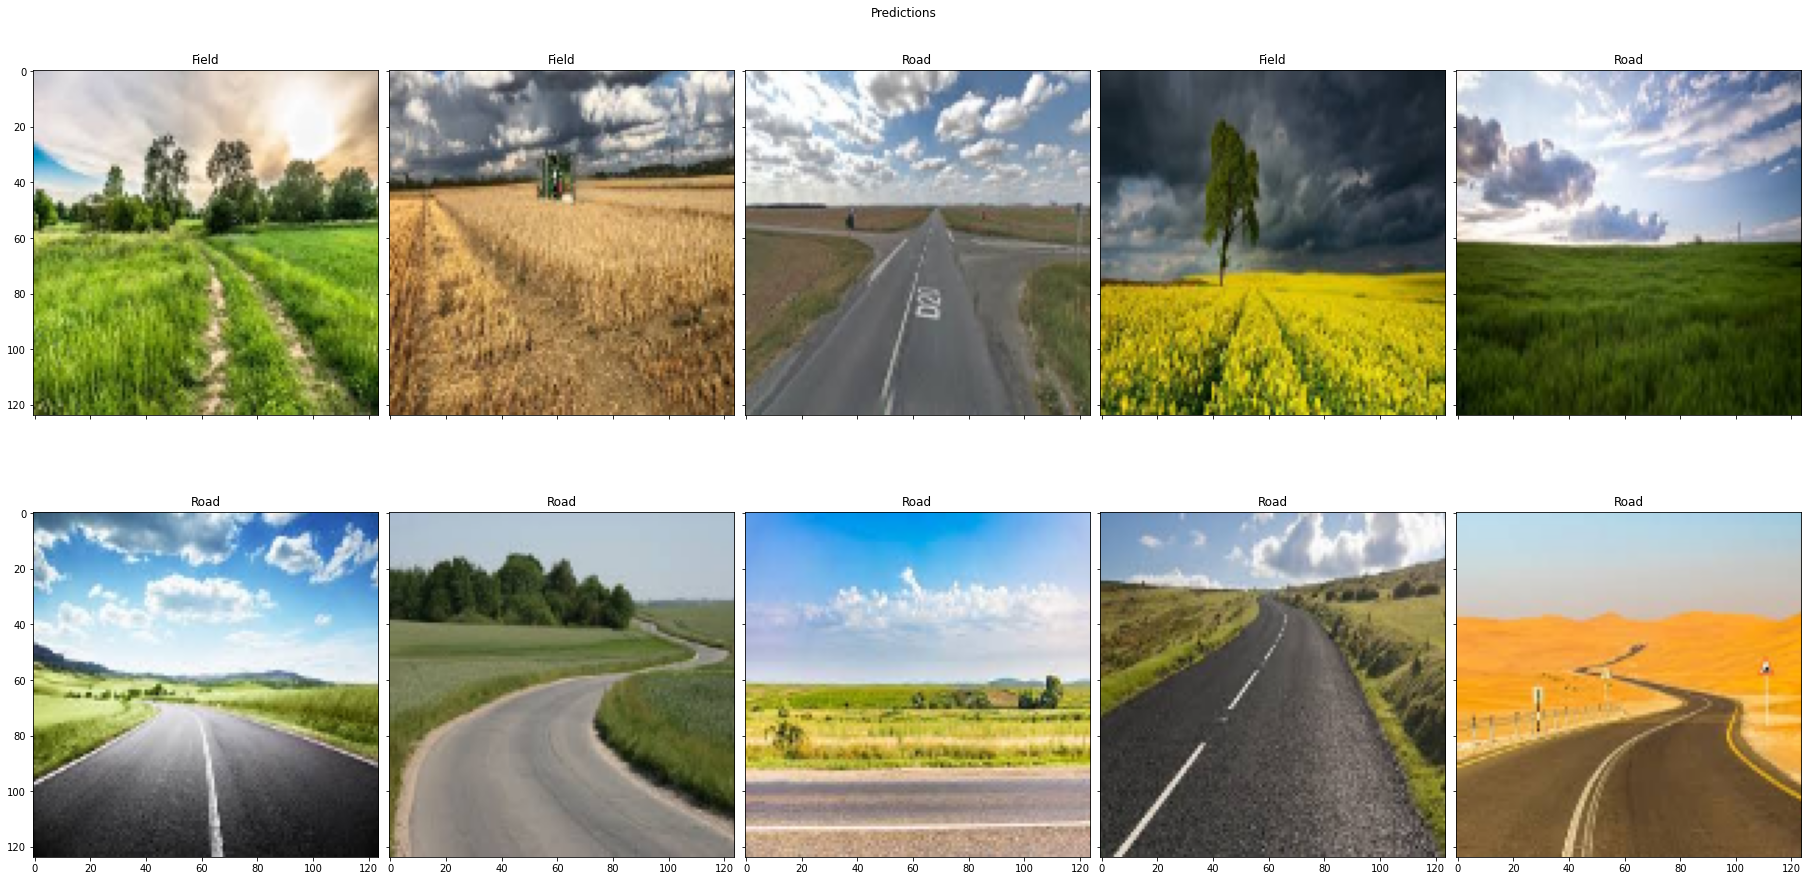

In [ ]:
##Predictions :

fig,ax = plt.subplots(2,5,sharex=True, sharey=True,figsize=(25,12.5),constrained_layout=True) 
i=0
j=0
path = "/content/dataset/test"
for img in os.listdir(path):
    
    img_array = cv2.imread(os.path.join(path,img))
    im_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    fig.suptitle('Predictions')
    im_rgb =cv2.resize(im_rgb,(image_size,image_size))
    ax[i,j].imshow(im_rgb)
    im_rgb =cv2.resize(im_rgb,(image_size,image_size))
    im_rgb = np.array(im_rgb).reshape(-1,image_size,image_size,3)
    im_rgb = im_rgb/255
    y=np.round(model.predict(im_rgb))
    if y == 0 :   ax[i,j].set_title("Field")
    elif y == 1 : ax[i,j].set_title("Road")
    i+=1
    if i==2: j+=1;i=0
    
plt.savefig("Predictions.jpg")

plt.show()
